# Execution Algorithms: VWAP

It is important to excercise caution while attempting to execute orders especially with large volumes in the financial markets, more so in case of instruments of low liquidity. A poorly executed trade can result in a large slippage and a simple solution can be to split a large order into many smaller orders over a period of time. 

A common approach to execute an order is to trade it on the volume weighted average price (VWAP) based on historical trading volumes.
We create volume profiles over a time interval and submit orders at the VWAP of each of these intervals with a quantity that can be executed during that interval. The goal is to have an average execution price close to (or ideally better than) the VWAP of the instrument over the trading interval. 


Here we will look at 2 weeks of historical data for a ticker from 2021-10-25 until 2021-11-05. The last day, 2021-11-08, will be used for backtesting our execution strategy.

The output of our execution algorithm will be a trading schedule to be followed over the course of the "execution day", our average execution price and the overall VWAP for the day.



In [1]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Mounted at /content/gdrive


In [3]:
# Read the csv
df = pd.read_csv('/content/gdrive/MyDrive/Interview Prep/Quant/Interview Archives/CLSA/Assignment/tick_data_sample.csv')

# 1. Data Pre-Processing



**Data Formatting**

We begin by formatting the data to a more usable format using the following steps:
1.   Pivotting the key-value table on a fresh index which is unique for each record. 
2.   Casting certain columns to better suited data types.
3.   Dropping redundant columns and reordering the rest. 
4.   We notice that data is already sorted on date and time_ns which is exactly what we need 



**Binning**

1.   We create our bins on the time in seconds (300 seconds each) starting 32400 (seconds until 9:00 when trading begins) and ending with the last bin in the range (63000, 63300] which represents the seconds until 17:35 when the trading stops forming 103 bins in total 5-minute each.  
2.   We notice some trades slightly overflowing the 17:35 time boundary which we categorise in the last bin (17:30, 17:35] as well.



**Data Splitting**

Lastly, we split our data into in-sample and out-sample for our backtest before we model it. 

1.   In-Sample Data (df_is): 2021-10-25 - 2021-11-05
2.   Out-Sample Data (df_os): 2021-11-08 





In [4]:
# Pivot the key-value table by generating a "new index" using groupby
df['index'] = df.groupby(['key']).cumcount()
df = df.pivot(index='index', columns='key', values='value')

# Clean up the pivoted df: fix data types for columns, remove extra cols, re-order for readability
df = df.rename_axis(None, axis=1)

df = df.drop(['arrival_seqnb', 'exch_seqnb', 'msg_type', 'nb_ask', 'nb_bid'], axis=1)

df['date'] = pd.to_datetime(df['date'], format='%y-%m-%d')
df = df.astype({'time_ns':int, 'price':float, 'size':int})

first_cols = ['date', 'trade_id']
last_cols = [col for col in df.columns if col not in first_cols]
df = df[first_cols + last_cols]

date
2021-10-25    21297
2021-10-26    20604
2021-10-27    12922
2021-10-28    14358
2021-10-29    16720
2021-11-01    17438
2021-11-02    16812
2021-11-03    15940
2021-11-04    17187
2021-11-05    32004
2021-11-08    23374
Name: date, dtype: int64

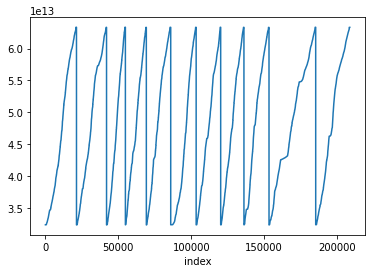

In [5]:
# Visualising the dates for which we have data and the number of trades for each of them
df.groupby(['date'])['date'].count()

# Visiualising the time_ns: Looks pre-sorted 
df.time_ns.plot()

In [6]:
# Binning in 5 minute intervals
df['time_s']  = df['time_ns']/1e9

# Set up bins starting 9:00 - 9:05 (labelled 0) and ending 17:30 - 17:35 (labelled 102)
bins = range(9*60*60, 17*60*60 + 40*60, 300)
labels = range(len(bins)-1)
df['bin'] = pd.cut(df['time_s'],bins, labels= labels)

# Quick check to see if all of these non-binned indices are the "slightly-overflowing" EOD trades
np.where((df[df['bin'].isnull()]['time_s'] - 17*60*60)/60 < 35)

# Assign the above non-binned indices to the last bin
df['bin'].fillna(value = labels[-1], inplace = True)

(array([], dtype=int64),)

In [7]:
# Segregate in-sample and out-sample data
df_is = df[df['date']<'2021-11-08'].copy()
df_os = df[df['date'] == '2021-11-08'].copy()

# 2. VWAP Execution Modelling

**Historical Volume Curve**

We begin with building our historical volume curve df_vc which provides the average qty of the instrument traded in each bin over the past two weeks in the in-sample data df_is


**VWAP Execution**

We define a function vwap_exec which for a given set of inputs (below) executes the standard VWAP model. The different inputs in the function signature are discussed below:



1.   **Historical Volume Curve (df_vc)**

2.   **Out-Sample dataset (df_os)** : Dataset to run our back-test against. 

3.   **Quantity (qty)**: Desired quantity to buy/sell

4.   **Base Participation Rate (bpr)** (optional argument): This represents the % of the total volume of each time window we would like to capture for our execution. Higher Values (~0.05) allow for aggressive executions - targetting order completion before EOD. 
In the default case (0), the algorithm tries to space volumes across all time periods with a very conservative bpr based on the historical volume curve. *bpr_default = qty / historical_daily_average_volume*

5.   **Tolerance Limit (tl)** (optional argument): Sets an upper-cap to the bpr to limit the qty executed to avoid over-aggressive executions. 
We can end up with a high bpr if: 

          *   The default bpr calibrated was too high due to high qty
          *   The passed bpr arg was low for the passed qty and hence the algorithm tried to increase it to execute the entire qty


In either of the above cases, we do not want the bpr over a certain limit as we risk moving the markets and paying higher slippages. Tolerance Limit represents the extent to which we are willing to increase our bpr. Defaults to 0.5 (5%) implying the maximum possible bpr = 0.5



 




In [8]:
# Setup the volume curve using the past two weeks data
df_vc = df_is[['bin', 'size']].groupby(by = ['bin']).sum()/df_is['date'].nunique()

In [9]:
def vwap_exec(df_vc, df_os, qty, bpr=0, tl=0.1):
  
  hist_avg_vol = df_vc['size'].sum()

  # Check if the bpr arg was not passed and defaulted to 0
  if bpr == 0:
    # Set a default value based on historical volume curve
    bpr = qty / hist_avg_vol

  # If a bpr arg was passed but it is low to accomodate the entire qty adjust it accordingly
  elif (qty > bpr*hist_avg_vol):
    bpr = qty / hist_avg_vol

  # Check if the bpr callibrated above is beyond the accepted tolerance limit. Hard Limit it to tl
  if bpr > tl:
    bpr = tl # Re-adjust the bpr to its max limit
    qty = bpr*hist_avg_vol # re-adjust qty to its max limit given bpr == tl
    print("The given qty can't be executed to full for the chosen bpr and tl, re-adjusting to " + str(qty))

  print("Computing for bpr: " + str(bpr) + ', tl: ' + str(tl) + ', qty: ' + str(qty))


  # Define participation sizes for each window based on the base participation rate
  df_vc['part_size'] = bpr*(df_vc['size'].values)
  df_vc['cum_part_size'] = df_vc['part_size'].cumsum()

  # Find the window where the cumulative participation size >= qty marking the end our execution window
  idx = df_vc['cum_part_size'].ge(qty).idxmax()

  #Setup an execution profile based on the windows we intend to participate on "idx" given our bpr and tl
  df_vc = df_vc.loc[df_vc.index <= idx]
  df_vc['exec_size'] = df_vc['part_size'].values

  # Remove the surplus quantity (if present) from the last execution window
  df_vc.at[df_vc.index[-1], 'exec_size'] = (df_vc.at[df_vc.index[-1], 'exec_size'] - (df_vc.at[df_vc.index[-1], 'cum_part_size'] - qty))

  df_os['price_vol'] = df_os['price']*df_os['size']

  # Setting up our final execution dataframe to be output
  df_exec = df_os[['bin','price_vol','size']].groupby(by = ['bin']).sum().copy()

  # Calculate the bin VWAP to estimate the execution price for each bins
  df_exec['vwap'] = df_exec['price_vol']/df_exec['size']

  # Join the volume profile modelled using the historical volume curve (df_vc) to be executed in each time bin on '2021-11-08' (df_exec) 
  df_exec = df_exec.join(df_vc['exec_size'])
  df_exec['exec_size'].fillna(value = 0, inplace = True)


  return df_exec

# 3. Model Evaluation

We execute the model with our parameters as described below.
An **interesting choice** here is that we run the model with the default base participation rate as the assignment does not mention any aggressiveness desired for a different bpr.

We space our execution around the entire day. 

It appears that our execution VWAP was actually higher than the VWAP for the entire day by 6.7 bips. 



**Volume Slippage**

I'm not perfectly clear by what's meant with volume slippage so it is interpreted as the difference of the target volume and the actual available volume for the time period which in our case is zero as ample volume is availabe for each time bin. 

In [10]:
# Run the execution model back-tester
df_exec = vwap_exec(df_vc, df_os, 20000)

# Calculate the Total Execution VWAP
df_exec['exec_price_vol'] = df_exec['vwap']*df_exec['exec_size']
exec_vwap = df_exec['exec_price_vol'].sum()/df_exec['exec_size'].sum()

# Calculate the entire day VWAP for '2021-11-08'
day_vwap = df_exec['price_vol'].sum()/df_exec['size'].sum()

# Calculate the volume slippage
df_exec['vol_slippage'] = np.maximum(0, df_exec['exec_size'] - df_exec['size'])


Computing for bpr: 0.013942234395032158, tl: 0.1, qty: 20000


In [13]:
df_exec.head(5)
df_exec.tail(5)

,price_vol,size,vwap,exec_size,exec_price_vol,vol_slippage
bin,,,,,,
0,5027684.30,45740,109.918765,661.278783,72686.947002,0.0
1,1454952.94,13214,110.106928,202.092688,22251.804897,0.0
2,2472084.74,22463,110.051406,237.211782,26105.490178,0.0
3,637989.46,5797,110.055108,147.711002,16256.350283,0.0
4,1459007.42,13278,109.881565,163.029335,17913.918495,0.0


,price_vol,size,vwap,exec_size,exec_price_vol,vol_slippage
bin,,,,,,
98,2085005.60,19152,108.866207,128.215576,13958.343455,0.0
99,2545309.04,23408,108.736716,121.602774,13222.686278,0.0
100,2583135.90,23762,108.708690,203.058884,22074.265386,0.0
101,2620846.26,24115,108.681164,184.538020,20055.806765,0.0
102,63566789.58,584361,108.780000,7563.429324,822749.841864,0.0


In [14]:
print("The execution VWAP price is: " + str(exec_vwap))
print("The VWAP for the day is: " + str(day_vwap)) 
print("The bips difference is: " + str((exec_vwap - day_vwap)*1e4/day_vwap))
print("The volume slippage is: " + str(df_exec['vol_slippage'].sum()))

The execution VWAP price is: 109.2328859253725
The VWAP for the day is: 109.15971371358529
The bips difference is: 6.703224962571795
The volume slippage is: 0.0


# 3. Closing Thoughts: Scalability

As we notice all operations are vectorised so they should be as quick as python can get. 
We could not notice any pain points with the data we have which are computationally intensive. 
One candidate could be the binning with pd.cut which can be further optimised using a "numba loop"  
